In [56]:
import itertools
import os
import zipfile
import csv
import textwrap

from difflib import SequenceMatcher
from pprint import pprint

import spacy
import numpy
import pandas
import umap

from headless import load_pages
from scipy.spatial import KDTree

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.palettes import magma

output_notebook()

Loading BokehJS ...

In [3]:
en_nlp = spacy.load('en_core_web_md', disable=['tagger', 'parser', 'ner'])

In [130]:
N_BANDS = 50

def htid_url(htid):
    htid = htid.replace('+', ':').replace('=', '/')
    return 'https://babel.hathitrust.org/cgi/pt?id={}'.format(htid)

def path_to_htid(path):
    htid = os.path.split(path)[-1]
    htid = os.path.splitext(htid)[0]
    return htid.replace('+', ':').replace('=', '/')

def volume_paths(path):
    """List all zip files and subfolders in the given folder."""
    files = (os.path.join(path, f) for f in sorted(os.listdir(path)))
    return [f for f in files if os.path.isdir(f) or f.endswith('.zip')]

def numpy_paths(path):
    """List all numpy files in the given folder."""
    files = (os.path.join(path, f) for f in sorted(os.listdir(path)))
    return [f for f in files if f.endswith('.npy')]

def load_one_sp_embedding(volume_path):
    """Parse the text of one volume and extract word vectors."""
    sp_text = en_nlp.pipe(load_pages(volume_path))
    return numpy.array([tok.vector.reshape(-1) for doc in sp_text for tok in doc if not tok.is_space])

def piecewise_avg(vec, n_groups):
    """Divide a vector into pieces and return the average for each."""
    size = len(vec) / n_groups
    ends = []
    for i in range(1, n_groups + 1):
        ends.append(int(size * i))
    ends[-1] = len(vec)
    
    sums = []
    start = 0
    for end in ends:
        sums.append(vec[start:end].sum() / (end - start))
        start = end
        
    return numpy.array(sums)
        
def embedding_fft(sp_embedding, n_bands=N_BANDS):
    """
    Perform a Fourier transform on all the dimensions of an
    array of word embeddings extracted from a document. 
    `sp_embedding` is assumed to be an array with a row
    for each document, and a column for each dimension of 
    the underlying word embedding vector model.
    """
    fft_cols = []
    n_groups = 1
    while n_groups < n_bands * 10:
        n_groups *= 2
        
    for col in range(sp_embedding.shape[1]):
        vec = sp_embedding[:, col]
        vec = piecewise_avg(vec, n_groups)
        fft = numpy.fft.rfft(vec)
        fft_cols.append(fft[:n_bands])
    
    return numpy.array(fft_cols)

def flatten_fft(emb_fft, start=0, end=None, drop_zero_imag=False):
    """Reshape an fft array into a single vector."""
    complex_vec = numpy.array(emb_fft)[:, start:end].reshape(-1)
    
    # Check to see if all imaginary values are zero, and if so only include real
    if drop_zero_imag and complex_vec.imag.ravel().sum() == 0:
        return complex_vec.real
    else:
        return numpy.array([x for r_i in zip(complex_vec.real, complex_vec.imag)
                            for x in r_i])

def unflatten_vec(doc_vector):
    """Turn a document vector back into an fft array."""
    array = doc_vector.reshape(300, -1)  # This hard-codes values that should be parameters.
    real = array[:, ::2]
    imag = array[:, 1::2]
    return real + imag * 1j

def slice_vec_bands(doc_vectors, start=0, end=None):
    return numpy.array([flatten_fft(unflatten_vec(dv), start, end, drop_zero_imag=True)
                        for dv in doc_vectors])
    
def test_fft_reshape(volume_path):
    """A test of vector-array conversion routines."""
    assert _test_fft_reshape_one(volume_path)

def _test_fft_reshape_one(folder):
    emb = load_one_sp_embedding(folder)
    
    fft_orig = embedding_fft(emb)
    
    fft_complex = unflatten_vec(flatten_fft(fft_orig))
    return (fft_orig == fft_complex).all()

def save_embedding_ffts(source_path, dest_path=None):
    dest_path = source_path if dest_path is None else dest_path
    vol_paths = volume_paths(source_path)
    vol_paths = [os.path.split(vp)[-1] for vp in vol_paths]
    vol_paths = [vp if not vp.endswith('.zip') else vp[:-4] for vp in vol_paths]
    new_paths = [os.path.join(dest_path, vp) for vp in vol_paths]
    
    sp_embeddings = (load_one_sp_embedding(v) for v in vol_paths)
    emb_ffts = (embedding_fft(e) for e in sp_embeddings)
    for emb, np in zip(emb_ffts, new_paths):
        numpy.save(np, emb) 
    
def load_embedding_fft_array(path, start=0, end=None, 
                             reload=False, htid_test=None, _cache={}):
    if (reload or not _cache or _cache['start'] != start or 
                _cache['end'] != end or htid_test is not None):
        if htid_test is not None:
            assert [path_to_htid(p) for p in numpy_paths(path)] == list(htid_test)
        _cache['start'] = start
        _cache['end'] = end
        _cache['data'] = numpy.array([flatten_fft(numpy.load(f), start, end) 
                                      for f in numpy_paths(path)])  
    return _cache['data']

# def load_embedding_fft_metadata(metadata_path, fft_path, csv_delim='\t', htid_col='htid'):
def load_metadata(metadata_path, fft_path, csv_delim='\t', htid_col='htid'):
    ids = [path_to_htid(p)
           for p in numpy_paths(fft_path)]
    metadata = (pandas
                .read_csv(metadata_path, delimiter=csv_delim)
                .drop_duplicates(htid_col)
                .set_index(htid_col))
    return metadata.reindex(ids, fill_value='[metadata missing]')

def load_fft_metadata(fft_path, metadata_path, start=0, end=None, reload=False,
                      csv_delim='\t', htid_col='htid'):
    metadata = load_metadata(metadata_path, fft_path, csv_delim, htid_col)
    fft_arr = load_embedding_fft_array(fft_path, start, end, reload, metadata.index)
    return fft_arr, metadata

def deduplicator(data, **umap_kwargs):
    data_umap = umap.UMAP(**umap_kwargs).fit_transform(data)
    data_kd = KDTree(data_umap)
    def deduplicate(distance):
        pairs = data_kd.query_pairs(distance)
        return set(frozenset(p) for p in pairs)
    return deduplicate

def string_similarity(a, b):
    return SequenceMatcher(a=a, b=b).ratio()

def show_dataset(folder, n=10):
    volumes = volume_paths(folder)
    for v in volumes:
        print(load_pages(v)[0][0:500])

def show_umap(data, n_neighbors=20, min_dist=0.001, metric='euclidean'):
    um = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    vis = um.fit_transform(data)
    plt.gca().axis('equal')
    plt.scatter(vis[:, 0], 
                vis[:, 1], 
                c=[i / len(vis) for i in range(len(vis))],
                cmap='plasma')
    plt.show()

def umap_color(metadata, color_field, n_colors, dtype=None, palette=magma):
    palette = palette(n_colors)
    if color_field is None:
        return [palette[n_colors // 2]] * len(metadata)
    
    if dtype is None:
        dtype = type(metadata[color_field][0])
    field = [f if isinstance(f, dtype) else dtype() 
             for f in metadata[color_field]]
    field_rank = {f: i / len(field) for i, f in enumerate(sorted(field))}
    return [palette[int(field_rank[f] * n_colors)] for f in field]

def show_umap_bokeh(data, metadata, color_field=None, n_neighbors=20, min_dist=0.001, metric='euclidean'):
    um = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    vis = um.fit_transform(data)
    color = umap_color(metadata, color_field, 20, dtype=int)
    scatter_data = pandas.DataFrame({'umap_1': vis[:, 0], 
                                     'umap_2': vis[:, 1],
                                     'color': color,
                                     'htid': list(metadata.index),
                                     'title': ['<br>'.join(textwrap.wrap(t)) 
                                               for t in metadata['title']],
                                     'author': list(metadata['author']),
                                     'pub_date': list(metadata['pub_date'])
    })
    
    plot_figure = figure(
        title=('UMAP Projection of Phasor vectors for ~1000 '
               'random HathiTrust volumes (colored by {})'.format(color_field)),
        plot_width=800,
        plot_height=800,
        tools=('pan, wheel_zoom, reset')
    )

    plot_figure.add_tools(HoverTool(
        tooltips=("<div><span style='font-size: 10px'>@htid{safe}</span></div>"
                  "<div><span style='font-size: 10px'>@author{safe}</span></div>"
                  "<div><span style='font-size: 10px'>@title{safe}</span></div>"
                  "<div><span style='font-size: 10px'>@pub_date{safe}</span></div>"
        )
    ))

    plot_figure.circle(
        'umap_1',
        'umap_2',
        color='color',
        source=scatter_data,
    )

    show(plot_figure)


In [42]:
# path_to_volumes = '/media/secure_volume/workset/orig'
# path_to_fft = '/media/secure_volume/workset/fft_npy'
# path_to_meta = '../fiction-rand-penn-1072.tsv'
path_to_volumes = '../ht-open-test-data/gov_docs/'
path_to_fft = '../ht-open-test-data/gov_docs_fft'
path_to_meta = '../ht-open-test-data/gov_docs_fakemeta.csv'
# path_to_volumes = '../ht-open-test-data/fiction_998/'
# path_to_fft = '../ht-open-test-data/fiction_fft'

In [43]:
for test_path in volume_paths(path_to_volumes)[:3]:
    print('testing with {}'.format(test_path))
    try:
        test_fft_reshape(test_path)
    except Exception as e:
        print('skipping {} -- {}: {}'.format(test_path, type(e), e))

testing with ../ht-open-test-data/gov_docs/0314624,0001,001.zip
testing with ../ht-open-test-data/gov_docs/0962976,1912,001.zip
testing with ../ht-open-test-data/gov_docs/0962976,1912,002.zip


In [44]:
# save_embedding_ffts(path_to_volumes, path_to_fft)

In [120]:
data, metadata = load_fft_metadata(path_to_fft, path_to_meta, end=20)
show_umap_bokeh(
    data,
    metadata
)

In [131]:
dedupe_slice_A = deduplicator(slice_vec_bands(data, start=0, end=None),
                              n_neighbors=5, n_components=10, metric='euclidean')
dedupe_slice_1 = deduplicator(slice_vec_bands(data, start=0, end=1),
                              n_neighbors=5, n_components=10, metric='euclidean')
dedupe_slice_2 = deduplicator(slice_vec_bands(data, start=1, end=2),
                              n_neighbors=5, n_components=10, metric='euclidean')
dedupe_slice_3 = deduplicator(slice_vec_bands(data, start=2, end=3),
                              n_neighbors=5, n_components=10, metric='euclidean')

/Users/enderlej/.virtualenvs/th/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [137]:
pairs = dedupe_slice_1(0.010) | dedupe_slice_2(0.010) | dedupe_slice_3(0.010)
pairs_A = dedupe_slice_A(0.010)
print(len(pairs - pairs_A))
print(len(pairs_A - pairs))

41
17


In [109]:
likely_true_positive_count = sum(
    string_similarity(metadata['title'][a], metadata['title'][b]) >= 0.6
    for a, b in pairs
)
likely_true_positive_count

33

In [76]:
distances = [((data_umap[x] - data_umap[y]) ** 2).sum() ** 0.5 for x, y in pairs]
order = sorted(range(len(distances)), key=distances.__getitem__)
pairs_sorted = [pairs[i] for i in order]
distances = [distances[i] for i in order]

for a, b in pairs_sorted:
    a_id = metadata.index[a]
    b_id = metadata.index[b]
    a_ti = metadata['title'][a]
    b_ti = metadata['title'][b]
    a_au = metadata['author'][a]
    b_au = metadata['author'][b]
    d = ((data_umap[a] - data_umap[b]) ** 2).sum() ** 0.5
    s = string_similarity(a_ti, b_ti)
    if s < 0.6:
        continue

    print()
    print()
    print('10-D UMAP Distance: ', d)
    print(htid_url(a_id))
    print(a_au, " ~~ ", a_ti)
    print(htid_url(b_id))
    print(b_au, " ~~ ", b_ti)
    print()
    print('------')
    



10-D UMAP Distance:  3.3310032701712592e-06
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t1cj8zb60
Fake Author  ~~  Fake Title
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t71v5kt29
Fake Author  ~~  Fake Title

------


10-D UMAP Distance:  4.194789774665525e-06
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t1cj8zb60
Fake Author  ~~  Fake Title
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t6rx9bj9n
Fake Author  ~~  Fake Title

------


10-D UMAP Distance:  7.408412284773435e-06
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t6rx9bj9n
Fake Author  ~~  Fake Title
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t71v5kt29
Fake Author  ~~  Fake Title

------


10-D UMAP Distance:  1.0414366017346476e-05
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t71v5kt29
Fake Author  ~~  Fake Title
https://babel.hathitrust.org/cgi/pt?id=ark:/13960/t9r21cx38
Fake Author  ~~  Fake Title

------


10-D UMAP Distance:  1.277074775570437e-05
https://babel.hathitrust.org/cgi/pt?i

In [77]:
# for a, b in pair_ids:
#     diff = data_dict[a] - data_dict[b]
#     plt.plot(diff)
#     plt.show()

In [78]:
# dist between 10 smallest pairs in base space
pair_dists = numpy.array([((data[x] - data[y]) ** 2).sum() ** 0.5 
                          for x, y in pairs])
smallest_ix = pair_dists.argsort()[:10]
print("closest pairs in base space")
pprint(list(zip([pairs[i] for i in smallest_ix], pair_dists[smallest_ix])))

# dist between pairs in umap space
pair_umap_dists = numpy.array([((data_umap[x] - data_umap[y]) ** 2).sum() ** 0.5
                               for x, y in pairs])
smallest_ix = pair_umap_dists.argsort()[:10]
print("closest pairs in umap space")
pprint(list(zip([pairs[i] for i in smallest_ix], pair_umap_dists[smallest_ix])))

closest pairs in base space
[((243, 450), 11.021749508691268),
 ((304, 474), 16.92004452962714),
 ((342, 736), 18.821654289516225),
 ((738, 750), 21.610887378848716),
 ((309, 750), 21.81125304935107),
 ((309, 738), 22.17340617427946),
 ((469, 922), 24.571215224464645),
 ((738, 967), 32.01039882527877),
 ((309, 967), 40.5426870631057),
 ((750, 967), 47.53614918786636)]
closest pairs in umap space
[((309, 750), 3.3310032701712592e-06),
 ((309, 738), 4.194789774665525e-06),
 ((738, 750), 7.408412284773435e-06),
 ((750, 967), 1.0414366017346476e-05),
 ((309, 967), 1.277074775570437e-05),
 ((738, 967), 1.6463717223420487e-05),
 ((54, 55), 0.0033199838419109306),
 ((3, 24), 0.0035389502110694288),
 ((869, 981), 0.003731826548893779),
 ((678, 869), 0.003782679900863788)]


In [84]:
data_freq_array = [unflatten_vec(r) / len(data) for r in data]  # 300 rows, 20 cols in each array, ~1000 arrays

data_freq_mean = data_freq_array[0]
for dfa in data_freq_array[1:]:
    data_freq_mean += dfa

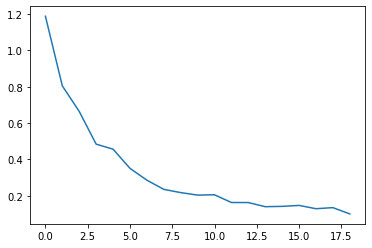

In [85]:
power_a = data_freq_mean[:, 1:].real
power_b = data_freq_mean[:, 1:].imag
power = (power_a * power_a + power_b * power_b) ** 0.5

mean_power = power.sum(axis=0) / 300
plt.plot(mean_power)

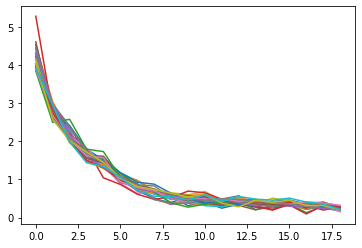

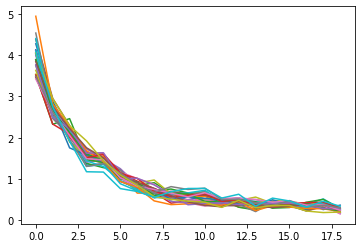

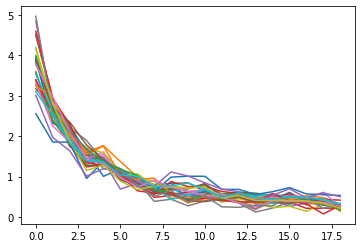

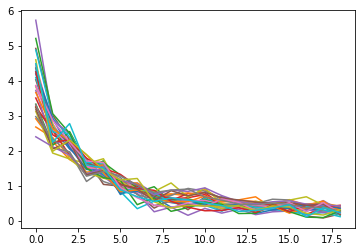

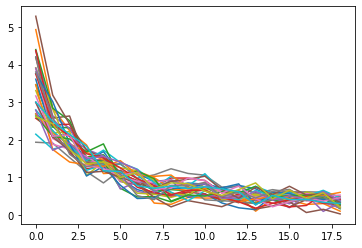

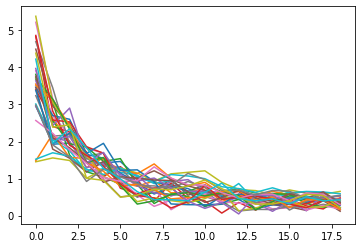

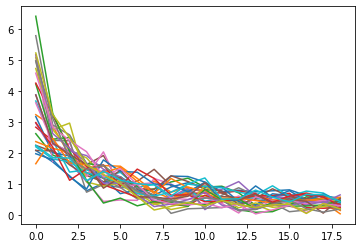

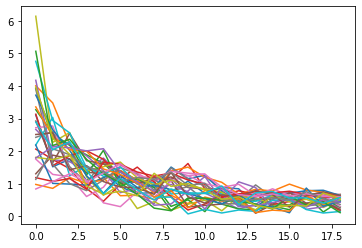

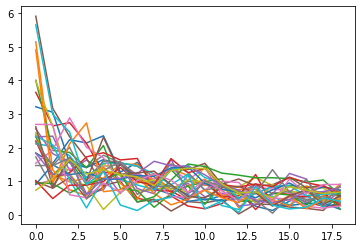

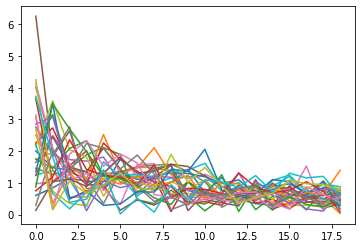

In [86]:
scaled_mean = mean_power / mean_power.mean()
scaled_power = power / power.mean(axis=0)
# scaled_rel_diff = []

scaled_diffs = numpy.array([(((scaled_power[i] - scaled_mean) / scaled_power[i]) ** 2).sum()
                            for i in range(len(power))])

scaled_diffs_argsort = scaled_diffs.argsort()

for chunk in range(10):
    for i in range(chunk * 30, chunk * 30 + 30):
        plt.plot(power[scaled_diffs_argsort[i]] / 
                 power[scaled_diffs_argsort[i]].mean())
    plt.show()